# Global RNN

In this notebook, I train a single ML model across sites and across target variables -- i.e. a global model. Darts syntax makes this task, at first glance, easier than the alternative, to train models for every target variable at every site individually. This is because all you have to do to train a global model is input a list of all the target variables and covariates to the Darts model, but this requires a bit more preprocessing, which is what most of this notebook is dedicated to. I will throw the pre-processing tidbits into utils when I have the chance.

In [4]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import os
from utils import (
    train_models, 
    make_stitched_series,
    get_variable_dataframes
)
import matplotlib.pyplot as plt
import ray 

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("aquatics-targets.csv.gz")

In [5]:
targets.head()

,datetime,site_id,variable,observation
0,2016-03-05,ARIK,chla,NaN
1,2016-03-05,ARIK,oxygen,NaN
2,2016-03-06,ARIK,chla,NaN
3,2016-03-06,ARIK,oxygen,NaN
4,2016-03-07,ARIK,chla,NaN


In the next 3 cells, I do a bit of preprocessing. In the first cell, I create DataFrames of the target variables for each site, such that all the target variable time series will share a common time index. Then, in the second cell, I perform bespoke filtering, where I fit 2 Gaussian Process Filters and stitch them together. This is to account for there being big and small gaps in the data, and one GP filter didn't seem to account well for both of these gaps. I do this latter task using Ray to parallelize the job.

In [6]:
site_dicts = [get_variable_dataframes(site, targets) 
                      for site in targets["site_id"].unique()]

/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_df_dict[variable] = targets[targets.site_id == site][
/home/rstudio/neon4cast-darts/utils.py:20: UserWarning: Boolean Series key will 

In [7]:
stitched_series_list = [make_stitched_series.remote(site_dict) for site_dict in site_dicts]

2023-06-13 22:24:45,055	INFO worker.py:1636 -- Started a local Ray instance.
(make_stitched_series pid=1255404) You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
(make_stitched_series pid=1255404) You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
(make_stitched_series pid=1255404) /home/rstudio/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a b

In [9]:
time_series = ray.get(stitched_series_list)

Putting names on the TimeSeries in case, I want to do debugging later.

In [10]:
named_ts_dict = {}# This will be a dictionary of dictionaries
site_names = targets["site_id"].unique()
for index, item in enumerate(time_series):
    name = site_names[index]
    named_ts_dict[name] = item

In [11]:
named_ts_dict

{'ARIK': {'oxygen': <TimeSeries (DataArray) (time: 2641, component: 1, sample: 500)>
  array([[[-1.41495359, -1.06444742, -0.51432986, ...,  0.94937088,
           -0.38553391, -0.51023351]],
  
         [[-1.42386118, -1.04706667, -0.49730176, ...,  1.02739264,
           -0.32872074, -0.57213605]],
  
         [[-1.43482493, -1.02292748, -0.479449  , ...,  1.10569492,
           -0.27481318, -0.633201  ]],
  
         ...,
  
         [[ 4.23254862,  4.18244989,  4.19851936, ...,  4.10170358,
            4.19495661,  4.18621162]],
  
         [[ 4.02433461,  4.04254795,  4.06506492, ...,  4.06134429,
            4.11240072,  4.04541891]],
  
         [[ 4.16505456,  4.19679356,  4.24750472, ...,  4.25087896,
            4.22498053,  4.21115116]]])
  Coordinates:
    * time       (time) datetime64[ns] 2016-03-05 2016-03-06 ... 2023-05-28
    * component  (component) <U1 '0'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          

Here, I go through each site to create an input and covariate that I will feed to the global model. I make some decisions like to add null TimeSeries if there is only one covariate attached -- this is to keep the dimensionality of all the covariates across sites the same. Uncertain how much these pre-processing decisions will affect the final outcome. 

In [39]:
inputs_covs_dict = {}
inputs_training = []
covs_training = []
for name in site_names:
    # Accessing the dictionary of every site, then going through each
    # time series recorded at that site
    site_dict = named_ts_dict[name]
    site_variables = list(site_dict.keys())
    variables_main = ["oxygen", "chla", "temperature"]
    variable_dict = {}
    for index, variable in enumerate(variables_main):
        variables_sub = ["oxygen", "chla", "temperature"]
        # Checking to see if the site has data for a variable
        if variable in site_variables:
            # If so I remove that variable on this dummy list
            # and then try to create covariate TS
            variables_sub.pop(index) 
            covs = []
            # Here I find covariates that were recorded at the
            # site
            for cov_variable in variables_sub:
                if cov_variable in site_variables:
                    covs.append(cov_variable)
            variables_sub.append(variable)
            # Then if there is more than one covariate, I stack them
            if len(covs) == 2:
                cov_sup = site_dict[covs[0]]
                cov_sub = site_dict[covs[1]]
                cov = cov_sub.concatenate(cov_sup, axis=1, ignore_time_axis=True)
                variable_value = [site_dict[variable], cov]
            elif len(covs) == 1:
                cov = site_dict[covs[0]]
                # I add a dummy covariate so that all covariates have same shape
                shape = (cov.n_timesteps, cov.n_components, cov.n_samples)
                null_array = np.zeros(shape)
                dummy_cov = TimeSeries.from_times_and_values(cov.time_index, null_array)
                cov = cov.concatenate(dummy_cov, axis=1, ignore_time_axis=True)
                variable_value = [site_dict[variable], cov]
            # Making the decision that if there are no covariates, don't add to the dictionary
            #else
            # Finally, we put the entry together for the dictionary
            variable_dict[variable] = variable_value
            inputs_training.append(site_dict[variable])
            covs_training.append(cov)
    inputs_covs_dict[name] = variable_dict

Then here, I do the final steps to put the inputs and covariates into a list to be fed to the model. Note that if the TimeSeries don't go up to the split date, I don't include them.

In [40]:
# Splitting training set and validation set
val_split = pd.Timestamp(year=2023, month=1, day=1)

val_set = []
inputs = []
cov_set = []
for index in range(len(inputs_training)):
    input = inputs_training[index]
    cov = covs_training[index]
    try:
        train_inp, val_inp = input.split_before(val_split)    
    except:
        continue
    inputs.append(train_inp)
    val_set.append(val_inp)
    cov_set.append(cov)

ValueError: Timestamp must be between 2017-08-26 00:00:00 and 2022-09-20 00:00:00
ValueError: Timestamp must be between 2017-08-26 00:00:00 and 2022-09-20 00:00:00
ValueError: Timestamp must be between 2018-08-17 00:00:00 and 2022-09-30 00:00:00
ValueError: Timestamp must be between 2018-08-17 00:00:00 and 2022-09-30 00:00:00
ValueError: Timestamp must be between 2018-08-17 00:00:00 and 2022-09-30 00:00:00


Now, I train the model. This takes a long time, so skip to loading cell to save time.

In [43]:
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import LaplaceLikelihood

rnn = BlockRNNModel(model="LSTM",
                            hidden_dim=32,
                            batch_size=8,
                            input_chunk_length=15,
                            output_chunk_length=34,
                            likelihood=LaplaceLikelihood(),
                            optimizer_kwargs={"lr": 1e-4},
                            n_rnn_layers=3,
                            random_state=0)

rnn.fit(inputs,
        past_covariates=cov_set,
        epochs=250, 
        verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.


BlockRNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, batch_size=8, input_chunk_length=15, output_chunk_length=34, likelihood=<darts.utils.likelihood_models.LaplaceLikelihood object at 0x7fc854e85f90>, optimizer_kwargs={'lr': 0.0001}, random_state=0)

Saving the model as it took a very long time to train.

In [45]:
rnn.save("global_block_rnn.pt")

Loading,

In [46]:
rnn_loaded = BlockRNNModel.load("global_block_rnn.pt")

Now, plotting some predictions.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

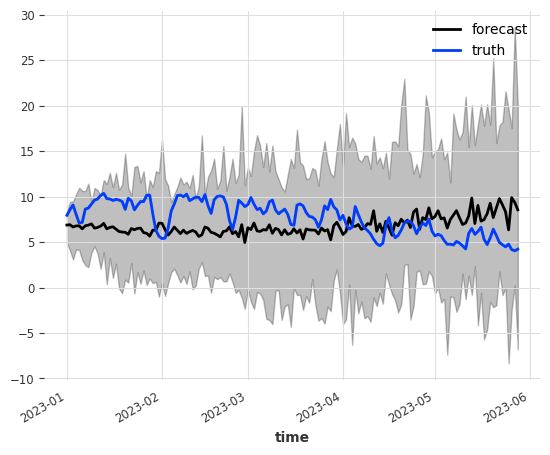

In [47]:
plt.clf()
preds = rnn_loaded.predict(series=inputs[0], 
                           past_covariates=cov_set[0], 
                           n=len(val_set[0]),
                           num_samples=50)
preds.plot(label="forecast")
val_set[0].plot(label="truth")
plt.show()

In [63]:
def make_plot(input_num):
    plt.clf()
    preds = rnn_loaded.predict(series=inputs[input_num], 
                               past_covariates=cov_set[input_num], 
                               n=30,#len(val_set[input_num]),
                               num_samples=50)
    preds.plot(label="forecast")
    val_set[input_num][:30].plot(label="truth")
    plt.show()

In [76]:
def make_plot_long_horizon(input_num):
    plt.clf()
    preds = rnn_loaded.predict(series=inputs[input_num], 
                               past_covariates=cov_set[input_num], 
                               n=len(val_set[input_num]),
                               num_samples=50)
    preds.plot(label="forecast")
    val_set[input_num].plot(label="truth")
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

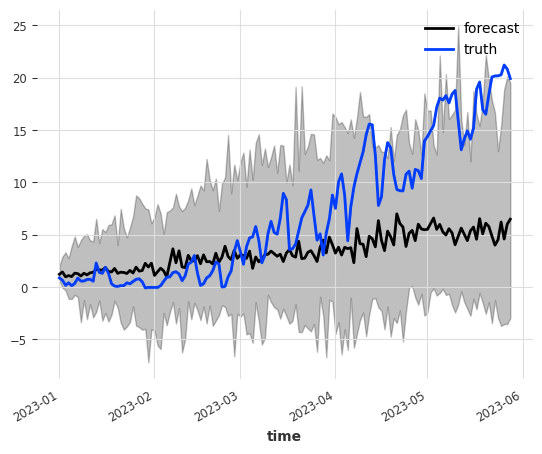

In [80]:
make_plot_long_horizon(1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

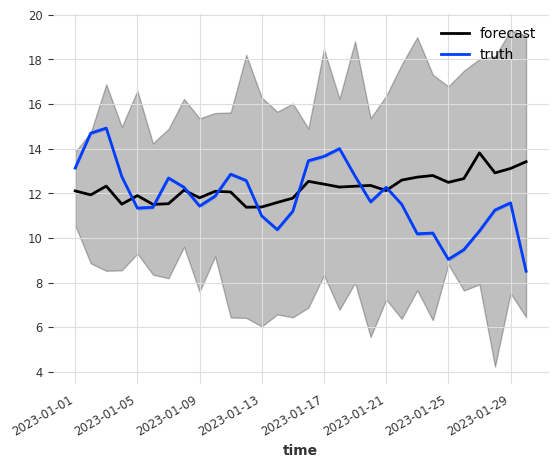

In [75]:
make_plot(10)

## Now training individual models on each site

In [81]:
named_ts_dict

{'ARIK': {'oxygen': <TimeSeries (DataArray) (time: 2641, component: 1, sample: 500)>
  array([[[-1.41495359, -1.06444742, -0.51432986, ...,  0.94937088,
           -0.38553391, -0.51023351]],
  
         [[-1.42386118, -1.04706667, -0.49730176, ...,  1.02739264,
           -0.32872074, -0.57213605]],
  
         [[-1.43482493, -1.02292748, -0.479449  , ...,  1.10569492,
           -0.27481318, -0.633201  ]],
  
         ...,
  
         [[ 4.23254862,  4.18244989,  4.19851936, ...,  4.10170358,
            4.19495661,  4.18621162]],
  
         [[ 4.02433461,  4.04254795,  4.06506492, ...,  4.06134429,
            4.11240072,  4.04541891]],
  
         [[ 4.16505456,  4.19679356,  4.24750472, ...,  4.25087896,
            4.22498053,  4.21115116]]])
  Coordinates:
    * time       (time) datetime64[ns] 2016-03-05 2016-03-06 ... 2023-05-28
    * component  (component) <U1 '0'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          

# So here I was using @ray.remote(num_gpus=num_gpus) above `train_models`

In [134]:
from darts.dataprocessing.transformers import Scaler
num_gpus = 1 / len(targets["site_id"].unique())

def train_models(site_stitched):
    """
    Returns a dictionary {site_id: [ml_model, scaled validation inputs, scaled validation covariates, scaler]}
    """
    models = {} 

    for var in site_stitched.keys():
        rnn = BlockRNNModel(model="LSTM",
                            hidden_dim=32,
                            batch_size=8,
                            input_chunk_length=15,
                            output_chunk_length=34,
                            likelihood=LaplaceLikelihood(),
                            optimizer_kwargs={"lr": 1e-4},
                            n_rnn_layers=3,
                            random_state=0)
        
        # Set a date to split between train and validation set
        val_split = pd.Timestamp(year=2023, month=1, day=1)
        try:
            train_set, val_set = site_stitched[var].split_before(val_split)
        except:
            continue
        
        scaler = Scaler()
        train_scaled = scaler.fit_transform(train_set)
        val_scaled = scaler.transform(val_set)
        # Dealing with covariates
        covariate_list = list(site_stitched.keys())
        covariate_list.remove(var)
        
        if len(covariate_list) == 0:
            train_covariates = None
            val_covariates = None
        elif len(covariate_list) == 1:
            covariates = site_stitched[covariate_list[0]]
        else:
            scaled_cov0 = scaler.transform(site_stitched[covariate_list[0]])
            scaled_cov1 = scaler.transform(site_stitched[covariate_list[1]])
            covariates = scaled_cov0.concatenate(scaled_cov1, 
                                                 axis=1, 
                                                 ignore_time_axis=True)

        # Now training model
        rnn.fit(train_scaled,
                past_covariates=covariates,
                epochs=250, 
                verbose=False)
    
        models[var] = [rnn, val_scaled, covariates, scaler]

    return models

(raylet) [2023-06-18 16:56:07,758 E 1255234 1255234] (raylet) node_manager.cc:3069: 14 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 6d5a2fd4de2f1df2432abc1197355b9b0df74f1cfc4552e1b9ace7ce, IP: 172.18.0.16) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.18.0.16`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(train_models pid=1598285) HPU available: False, using: 0 HPUs
(train_models pid=1598285) HPU available: False, us

In [112]:
individ_ = train_models(named_ts_dict["ARIK"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.


In [114]:
def plot_predictions(variable, dict_output):
    plt.clf()
    model_ = dict_output[variable][0]
    val_set_ = dict_output[variable][1]
    covs_ = dict_output[variable][2]
    predictions_ = model_.predict(n=len(val_set_), past_covariates=covs_, num_samples=50)
    predictions_.plot()
    val_set_.plot(label="truth")
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

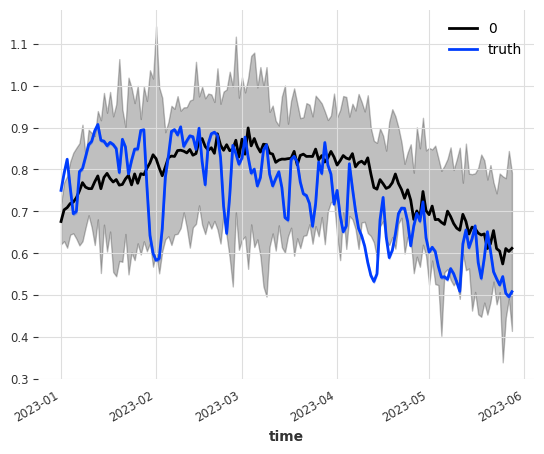

In [115]:
plot_predictions("oxygen", individ_)

In [125]:
len(targets["site_id"].unique())

34

# This was where I was calling ray task on individual models

In [135]:
individual_models_list = [train_models(named_ts_dict[site]) 
                              for site in targets["site_id"].unique()]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599074) HPU available: False, using: 0 HPUs
(train_models pid=1599332) GPU available: True (cuda), used: True
(train_models pid=1599332) TPU available: False, using: 0 TPU cores
(train_models pid=1599332) IPU available: False, using: 0 IPUs
(train_models pid=1599332) HPU available: False, using: 0 HPUs
(raylet) [2023-06-18 16:58:10,980 E 1255234 1255234] (raylet) node_manager.cc:3069: 11 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 6d5a2fd4de2f1df2432abc1197355b9b0df74f1cfc4552e1b9ace7ce, IP: 172.18.0.16) over the last time

In [119]:
models_list = ray.get(individual_models_list)

In [124]:
plot_predictions("oxygen", models_list[0])

AttributeError: 'NoneType' object has no attribute 'set_predict_parameters'

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_predictions(variable, dict_output):
    plt.clf()
    import pdb; pdb.set_trace()
    model_ = dict_output[variable][0]
    val_set_ = dict_output[variable][1]
    covs_ = dict_output[variable][2]
    predictions_ = model_.predict(n=len(val_set_), past_covariates=covs_, num_samples=50)
    predictions_.plot()
    val_set_.plot(label="truth")
    plt.show()